In [1]:
import CentralStreamingModel.biskewt.skewt as st
import matplotlib.pyplot as plt
import numpy as np
import importlib
import seaborn as sns
from CentralStreamingModel.projection.wrap_projection import skewt_los_pdf
from scipy.integrate import simps
from scipy.stats import t, norm
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.special import gamma
import tools
from scipy.misc import derivative

In [2]:
v_los = np.linspace(-30., 30., 100)
r = np.linspace(0.,150.,150)

vr_c = 2.
#vr_c= 1.
kappa = 40
skewness = -0.6

In [3]:
def w(r):
    return np.log10(r + 1)  + 1

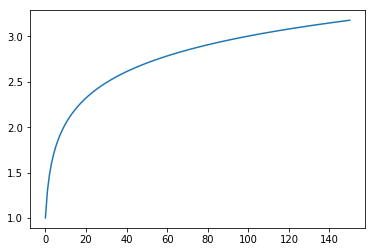

In [4]:
plt.plot(r, w(r))

In [5]:
mean, std, st_pdf, gauss_pdf = tools.gaussian_from_moments(r, v_los,
                        vr_c, w, skewness, kappa)


In [6]:
mean_bf, std_bf, st_pdf_bf, gauss_pdf_bf = tools.gaussian_best_fit(r,
                        v_los, vr_c, w, skewness, kappa)

In [7]:
mean_interp = interp1d(r, mean)
std_interp = interp1d(r, std)
std_square_interp = interp1d(r, std*std)

In [8]:
mean_interp_bf = interp1d(r, mean_bf)
std_interp_bf = interp1d(r, std_bf)

In [9]:
mean_from_parameters, std_from_parameters = tools.params2moments(r,
                        vr_c, w, skewness, kappa)

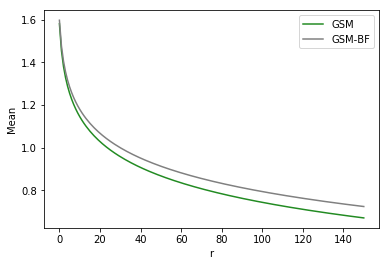

In [10]:
plt.plot(r, mean_interp(r), color = 'forestgreen',label = 'GSM')
plt.plot(r, mean_interp_bf(r), color='gray',label='GSM-BF')
#plt.plot(r, mean_from_parameters)
plt.xlabel('r')
plt.ylabel('Mean')
plt.legend()

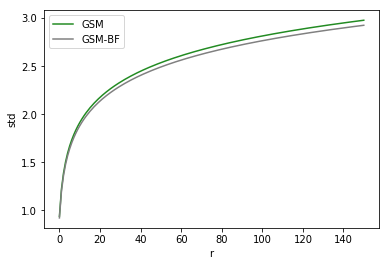

In [11]:
plt.plot(r, std_interp(r), color = 'forestgreen',label = 'GSM')
plt.plot(r, std_interp_bf(r), color='gray',label='GSM-BF')
#plt.plot(r, std_from_parameters)

plt.xlabel('r')
plt.ylabel('std')
plt.legend()

In [12]:
s = 33.5
rparallel = np.linspace(-100., 150., 1000)


In [13]:
gsm_moments = tools.gsm_params( mean_interp, std_interp)
gsm_integrand = tools.integrand_minus(rparallel, gsm_moments, s)

gsm_bf = tools.gsm_params( mean_interp_bf, std_interp_bf)
gsm_bf_integrand = tools.integrand_minus(rparallel, gsm_bf, s)

st = tools.stsm_params(v_los, vr_c, w, skewness, kappa,
                       truncate=True)
st_integrand = tools.integrand_minus(rparallel, st, s)


In [14]:
tools.integrate(st_integrand, rparallel)

1.0047377833609237

In [15]:
tools.integrate(gsm_integrand, rparallel)

1.0047360669336767

In [16]:
tools.integrate(gsm_bf_integrand, rparallel)

1.0045457515740548

In [17]:
mean = simps(v_los * st_pdf, v_los, axis = -1)

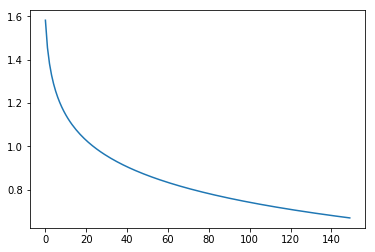

In [18]:
plt.plot(mean)

## Expansion around r = s

In [19]:
def approximate_gaussian(r, s, order = 2):
    v = (s - r) * np.sign(r)
    
    mean_s = mean_interp(s)
    std_s = std_interp(s)

    dmean_s =  derivative(mean_interp,s)
    dstd_s = derivative(std_interp,s)
    
    ddmean_s =  derivative(mean_interp,s, n=2)
    ddstd_s = derivative(std_interp,s, n=2)
    
    oo_gsm_integrand = norm.pdf( v , loc = mean_s, scale = std_s)

    a = dstd_s* (r - s)/std_s 
    b = dmean_s * (v - mean_s)/std_s**2 * (r - s)
    c = dstd_s *(v - mean_s)**2/std_s**3 *  (r - s)
    
    if order == 1:
        fo_gsm_integrand = oo_gsm_integrand * ( 1 - a + b + c)
        return fo_gsm_integrand
    
    
    e = (2 * dstd_s/std_s * ( (v - mean_s) * dmean_s/std_s**2  + \
                    (v - mean_s)**2 * dstd_s / std_s**3) ) * 0.5 * (r - s) **2
    
    f = ((v - mean_s)**2* dstd_s / std_s**3 + (v - mean_s) * dmean_s / std_s**2 ) **2 \
    * 0.5 * (r - s) **2
    
    g = ((v - mean_s) * ddmean_s / std_s**2 - 4 * (v-mean_s) * dmean_s * dstd_s / std_s**3 \
    - dmean_s**2/std_s**2 + (v - mean_s)**2 * ddstd_s / std_s**3  \
    - 3 * (v - mean_s)**2 *dstd_s**2/std_s**4 )* 0.5 * (r - s) **2
    
    h = (2 * dstd_s**2 / std_s**2  - ddstd_s /std_s) * 0.5 * (r - s) **2
    
    if order == 2:
        so_gsm_integrand = oo_gsm_integrand * (1 - a + b +c +e +f +g+h)
    
        return so_gsm_integrand
    

-0.005269657777423942


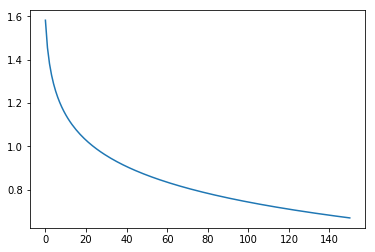

In [20]:
m1 = simps(v_los * st_pdf, v_los, axis = -1)

plt.plot(r, m1)

m1_inter = interp1d(r, m1)

dmean_s =  derivative(m1_inter,s)
print(dmean_s)

In [52]:
def approximate_gaussian_integral(s):

    m1 = simps(v_los * st_pdf, v_los, axis = -1)
    m2 = simps(v_los**2 * st_pdf, v_los, axis = -1)
    m3 = simps(v_los**3 * st_pdf, v_los, axis = -1)

    m1_inter = interp1d(r, m1)
    m2_inter = interp1d(r, m2)
    m3_inter = interp1d(r, m3)

    dmean_s =  derivative(m1_inter,s)
    ddstd_s = derivative(m2_inter,s, n=2)
    # dddm3_s = derivative(m3_inter,s, n=3)

    return 1 - (dmean_s) + 0.5 * ddstd_s# + 1./6. * dddm3_s

In [53]:
thresh = (rparallel > 20) & (rparallel < 50)

In [54]:
approximate_gaussian_integral(s)

1.004766683261141

In [55]:
print(simps(st_integrand[thresh], rparallel[thresh]))

1.0047376011061302


In [56]:
print(simps(gsm_integrand[thresh], rparallel[thresh]))

1.0047360606820654


In [57]:
tools.integrate(st_integrand, rparallel)

1.0047377833609237

In [58]:
tools.integrate(gsm_integrand, rparallel)

1.0047360669336767

In [59]:
tools.integrate(gsm_bf_integrand, rparallel)

1.0045457515740548

In [60]:
s_range = np.linspace(10,80.5,10)
gauss_int, gauss_approx, gauss_1approx, gauss_int_bf, st_int, gauss_direct = [], [], [], [], [], []
for s_value in s_range:
    st_int.append(tools.integrate(tools.integrand_minus(rparallel, st, s_value), rparallel))
    
    gauss_int.append(tools.integrate(tools.integrand_minus(rparallel, gsm_moments, s_value), rparallel))
    
    gauss_approx.append(tools.integrate(approximate_gaussian(rparallel, s_value, order=2), rparallel))
    gauss_1approx.append(tools.integrate(approximate_gaussian(rparallel, s_value, order=1), rparallel))
    
    gauss_int_bf.append(tools.integrate(tools.integrand_minus(rparallel, gsm_bf, s_value),
                                  rparallel)) 
    
    gauss_direct.append(approximate_gaussian_integral(s_value))

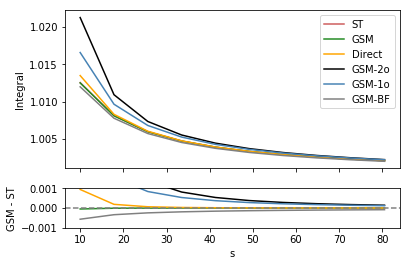

In [61]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})
ax1.plot(s_range,st_int, label = 'ST', color = 'indianred')
ax1.plot(s_range, gauss_int, label = 'GSM', color = 'forestgreen')
ax1.plot(s_range, gauss_direct, label = 'Direct', color = 'orange')

ax1.plot(s_range, gauss_approx, label = 'GSM-2o', color = 'black')
ax1.plot(s_range, gauss_1approx, label = 'GSM-1o', color = 'steelblue')

ax1.plot(s_range, gauss_int_bf, label = 'GSM-BF', color = 'gray')

ax2.plot(s_range, np.asarray(gauss_int_bf) - np.asarray(st_int),
         label = 'GSM-BF', color = 'gray')
ax2.plot(s_range,np.asarray(gauss_approx) - np.asarray(st_int),
         label = 'GSM-Expansion', color = 'black')

ax2.plot(s_range,np.asarray(gauss_1approx) - np.asarray(st_int),
         label = 'GSM-Expansion', color = 'steelblue')

ax2.plot(s_range, np.asarray(gauss_int) - np.asarray(st_int),
         label = 'GSM', color = 'forestgreen')

ax2.plot(s_range, np.asarray(gauss_direct) - np.asarray(st_int),
         label = 'GSM', color = 'orange')
ax1.set_ylabel('Integral')
ax2.set_ylabel('GSM - ST')

ax2.set_xlabel('s')
ax2.set_ylim(-0.001,0.001)
ax2.axhline(y = 0., linestyle='dashed', color='gray')
ax1.legend()

# check analytic/numeric derivative

In [96]:
b = (kappa/np.pi)**0.5 * gamma((kappa-1)/2.)/gamma(kappa/2.)
delta = skewness/np.sqrt(1 + skewness**2)
factor = kappa/(kappa - 2) - delta**2*b**2

mean = vr_c + (w(r)) * delta * b 
std = np.sqrt(factor) * w(r)


In [111]:
def dw_analytic(r):
    return 1/(np.log(10.)*r + np.log(10))

def ddw_analytic(r):
    return -(np.log(10.)*r + np.log(10))**(-2) * np.log(10.)

dmean_analytic = delta * b * dw_analytic(30)

In [98]:
dmean_s =  derivative(mean_interp,30)


In [99]:
dmean_s

-0.0058643900734005605

In [100]:
dmean_analytic

-0.005861729880657546

In [105]:
dstd_analytic = np.sqrt(factor)* dw_analytic(30)
ddstd_analytic = np.sqrt(factor)* ddw_analytic(30)

In [107]:
dstd_s =  derivative(std_interp,30)
ddstd_s =  derivative(std_interp,30, n=2)


In [103]:
dstd_s

0.013129826926904897

In [104]:
dstd_analytic

0.013123871001441564

In [112]:
ddstd_s

-0.00042366046879571684

In [113]:
ddstd_analytic

0.00042335067746585687